In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import wfdb  # For å lese .dat og .hea filer
from config import DATASET_DIR
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

## Download the data
This dataset is very large, will take several hours to download.

In [ ]:
!curl -O https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip

In [ ]:
!unzip -q ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip
!ls

## Preprocessing

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


Duration of ECG signal: 10.0 seconds


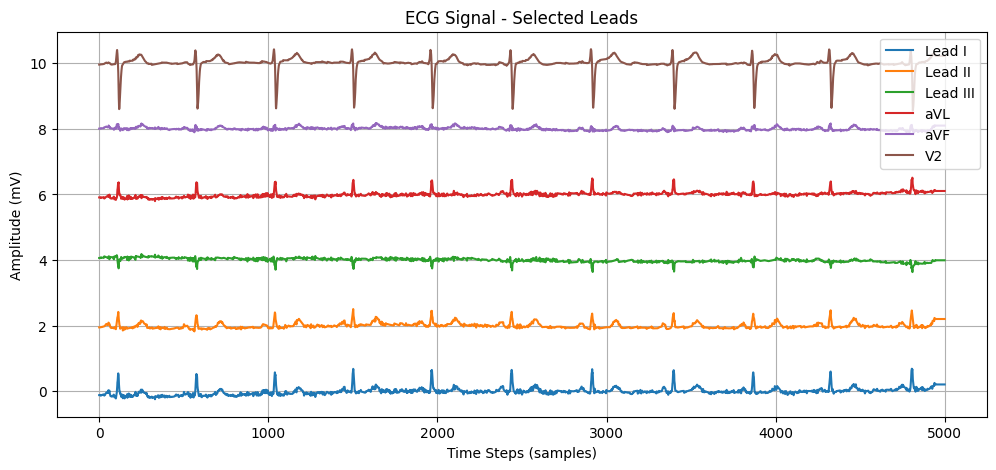

Unique label values: [0. 1.]
Distribution of diagnostic classes:
NORM: 9438.0 samples (43.30%)
MI: 4134.0 samples (18.96%)
STTC: 5078.0 samples (23.29%)
CD: 4891.0 samples (22.44%)
HYP: 2258.0 samples (10.36%)


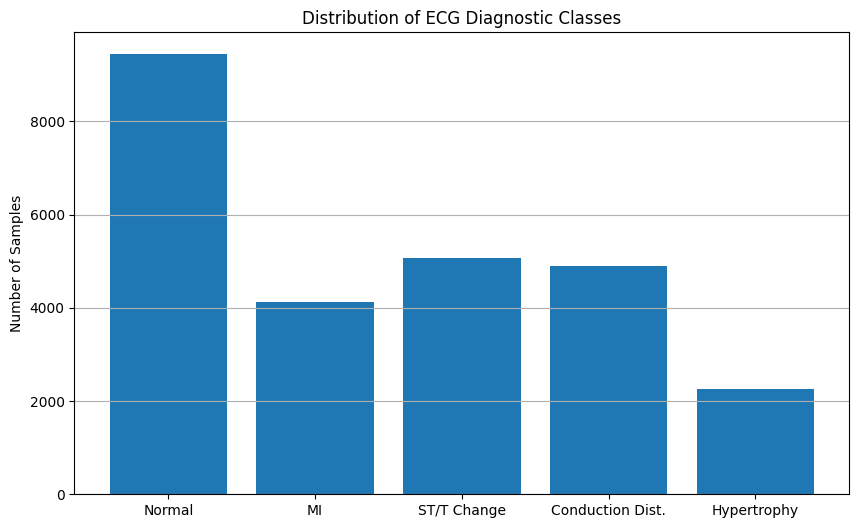

Number of multi-label records: 4390 (20.14%)


In [2]:
### **1️⃣ Load Dataset**
# Load metadata
df = pd.read_csv(os.path.join(DATASET_DIR, "ptbxl_database.csv"))
df_labels = pd.read_csv(os.path.join(DATASET_DIR, "scp_statements.csv"))

# Display dataset information
display(df.head())



### **2️⃣ Load & Preprocess ECG Signals Efficiently**
def load_ecg(record_name):
    """Loads ECG signal from PTB-XL .dat files."""
    file_path = os.path.join(DATASET_DIR, record_name)
    record = wfdb.rdsamp(file_path)[0]  # Extract raw ECG signal
    return record

# Load all ECGs into a NumPy array
ecg_signals = np.array([load_ecg(f) for f in df["filename_hr"]])

# Display duration of ECG signals
sampling_rate = 500  # PTB-XL default sampling rate
duration = ecg_signals.shape[1] / sampling_rate
print(f"Duration of ECG signal: {duration} seconds")



### **3️⃣ Select Relevant Leads**
FOCUS_LEADS = [0, 1, 2, 4, 5, 7]  # Lead I, Lead II, Lead III, aVL, aVF, V2
FOCUS_LEAD_NAMES = ["Lead I", "Lead II", "Lead III", "aVL", "aVF", "V2"]

# Extract only the selected leads
ecg_signals = ecg_signals[:, :, FOCUS_LEADS]



### **4️⃣ Visualize ECG Signals**
def plot_ecg(ecg_data, leads, title):
    """Plots ECG signals for selected leads with offsets."""
    plt.figure(figsize=(12, 5))
    for i in range(ecg_data.shape[1]):
        plt.plot(ecg_data[:, i] + (i * 2), label=leads[i])  # Offset each lead
    plt.title(title)
    plt.xlabel("Time Steps (samples)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot selected leads
plot_ecg(ecg_signals[0], FOCUS_LEAD_NAMES, "ECG Signal - Selected Leads")



### **5️⃣ Normalize ECG Signals**
# Normalize ECGs using vectorized StandardScaler
scaler = StandardScaler()
ecg_signals = np.array([scaler.fit_transform(ecg) for ecg in ecg_signals])



### **6️⃣ Zero-Padding & Truncating**
def preprocess_ecg(ecg_data, target_length=5000):
    """Ensure all ECG signals have the same length through zero-padding or truncation."""
    current_length = ecg_data.shape[0]
    if current_length > target_length:
        return ecg_data[:target_length, :]
    elif current_length < target_length:
        padded = np.zeros((target_length, ecg_data.shape[1]), dtype=ecg_data.dtype)
        padded[:current_length, :] = ecg_data
        return padded
    return ecg_data

# Apply padding/truncation in a single NumPy operation
ecg_signals = np.array([preprocess_ecg(ecg) for ecg in ecg_signals])



### **7️⃣ Multi-Label Disease Annotations (Optimized)**
def process_labels_optimized(df, df_labels):
    """Efficiently process multi-label disease annotations using merge instead of looping."""
    diagnostic_classes = ["NORM", "MI", "STTC", "CD", "HYP"]
    df["scp_codes"] = df["scp_codes"].apply(eval)
    expanded_rows = []
    for idx, row in df.iterrows():
        for code, value in row["scp_codes"].items():
            expanded_rows.append({"ecg_id": row["ecg_id"], "scp_code": code, "confidence": value})
    expanded_df = pd.DataFrame(expanded_rows)
    expanded_df = expanded_df.merge(df_labels, left_on="scp_code", right_on="Unnamed: 0", how="left")
    expanded_df = expanded_df[(expanded_df["confidence"] >= 50) & (expanded_df["diagnostic_class"].isin(diagnostic_classes))]
    df_labels_onehot = expanded_df.pivot_table(index="ecg_id", columns="diagnostic_class", aggfunc="size", fill_value=0)
    df = df.merge(df_labels_onehot, left_on="ecg_id", right_index=True, how="left").fillna(0)
    
    # Convert counts to binary: if a record has at least one annotation, mark as 1
    for col in diagnostic_classes:
        df[col] = (df[col] > 0).astype(np.float32)
    
    return df

# Apply label processing
df = process_labels_optimized(df, df_labels)

# Extract labels
target_columns = ["NORM", "MI", "STTC", "CD", "HYP"]
y = df[target_columns].values.astype(np.float32)

# Verify the labels are binary
print("Unique label values:", np.unique(y))
assert np.all(np.logical_or(y == 0, y == 1)), "Labels contain values other than 0 and 1"

# Distribution of diagnostic classes
print("Distribution of diagnostic classes:")
for diagnostic_class in target_columns:
    count = df[diagnostic_class].sum()
    percent = 100 * count / len(df)
    print(f"{diagnostic_class}: {count} samples ({percent:.2f}%)")

# Visualize label distribution
plt.figure(figsize=(10, 6))
label_counts = [df[col].sum() for col in target_columns]
plt.bar(["Normal", "MI", "ST/T Change", "Conduction Dist.", "Hypertrophy"], label_counts)
plt.title("Distribution of ECG Diagnostic Classes")
plt.ylabel("Number of Samples")
plt.grid(axis="y")
plt.show()

# Count number of multi-label cases
multi_label_count = (df[target_columns].sum(axis=1) > 1).sum()
print(f"Number of multi-label records: {multi_label_count} ({100*multi_label_count/len(df):.2f}%)")

In [3]:
# Convert DataFrame to NumPy arrays for model training
def convert_to_numpy(ecg_signals, df, target_columns):
    """Convert ECG signals and labels to NumPy arrays."""
    X = np.array(ecg_signals)
    y = df[target_columns].values
    return X, y

# Convert to NumPy arrays
X, y = convert_to_numpy(ecg_signals, df, target_columns)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (21799, 5000, 6)
Shape of y: (21799, 5)


In [4]:
# Split dataset into Train/Validation/Test Sets
y = y.astype(np.float32)

#X_train, y_train, X_temp, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
#X_val, y_val, X_test, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

X_train, y_train, X_temp, y_temp = iterative_train_test_split(X, y, test_size=0.4)
X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=0.5)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (13079, 5000, 6), (13079, 5)
Validation set shape: (4360, 5000, 6), (4360, 5)
Testing set shape: (4360, 5000, 6), (4360, 5)


ECG signals shape (X): (21799, 5000, 6)
Labels shape (y): (21799, 5)
Data type of X: float64
Data type of y: float32
Sample 0 ECG signal stats:
Min: -6.737897171144937 Max: 6.516415601964447 Mean: -3.600083194517841e-17
Corresponding label: [1. 0. 0. 0. 0.]
Sample 1 ECG signal stats:
Min: -7.927445906411916 Max: 6.676961041576104 Mean: -7.579122514774402e-18
Corresponding label: [1. 0. 0. 0. 0.]
Sample 2 ECG signal stats:
Min: -7.714822389048787 Max: 7.163033658568191 Mean: 7.579122514774402e-18
Corresponding label: [1. 0. 0. 0. 0.]


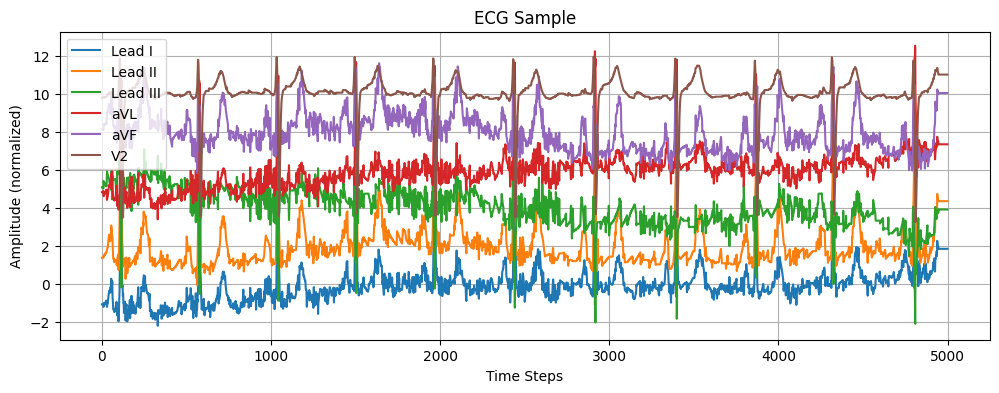

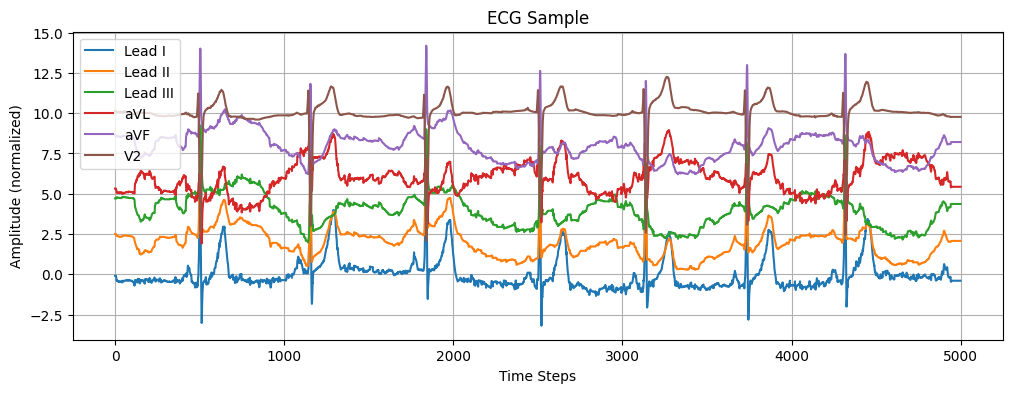

Distribution for NORM: {np.float32(0.0): np.int64(12361), np.float32(1.0): np.int64(9438)}
Distribution for MI: {np.float32(0.0): np.int64(17665), np.float32(1.0): np.int64(4134)}
Distribution for STTC: {np.float32(0.0): np.int64(16721), np.float32(1.0): np.int64(5078)}
Distribution for CD: {np.float32(0.0): np.int64(16908), np.float32(1.0): np.int64(4891)}
Distribution for HYP: {np.float32(0.0): np.int64(19541), np.float32(1.0): np.int64(2258)}
NORM    9438.0
MI      4134.0
STTC    5078.0
CD      4891.0
HYP     2258.0
dtype: float32
Any NaNs in X? False
Any Infs in X? False
Any NaNs in y? False
Any Infs in y? False


In [5]:
print("ECG signals shape (X):", X.shape)  # e.g., (num_samples, time_steps, num_leads)
print("Labels shape (y):", y.shape)       # e.g., (num_samples, num_classes)
print("Data type of X:", X.dtype)
print("Data type of y:", y.dtype)

# Display a few samples from X and y
for i in range(3):
    print(f"Sample {i} ECG signal stats:")
    print("Min:", X[i].min(), "Max:", X[i].max(), "Mean:", X[i].mean())
    print("Corresponding label:", y[i])



def plot_ecg_sample(ecg_sample, lead_names=None):
    plt.figure(figsize=(12, 4))
    num_leads = ecg_sample.shape[1]
    for i in range(num_leads):
        plt.plot(ecg_sample[:, i] + (i * 2), label=(lead_names[i] if lead_names else f"Lead {i}"))
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude (normalized)")
    plt.title("ECG Sample")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot a few samples
plot_ecg_sample(X[0], lead_names=FOCUS_LEAD_NAMES)
plot_ecg_sample(X[1], lead_names=FOCUS_LEAD_NAMES)




# For a NumPy array of labels:
for idx, class_name in enumerate(["NORM", "MI", "STTC", "CD", "HYP"]):
    unique, counts = np.unique(y[:, idx], return_counts=True)
    print(f"Distribution for {class_name}: {dict(zip(unique, counts))}")

# If you still have the DataFrame, you can use:
print(df[target_columns].sum())


assert np.all(np.logical_or(y == 0, y == 1)), "Labels contain values other than 0 and 1"



print("Any NaNs in X?", np.isnan(X).any())
print("Any Infs in X?", np.isinf(X).any())
print("Any NaNs in y?", np.isnan(y).any())
print("Any Infs in y?", np.isinf(y).any())


## Model Training

In [6]:
# Assuming X_train, y_train, X_val, y_val are defined from your preprocessing steps
input_shape = X_train.shape[1:]  # e.g., (5000, 6)
num_classes = y_train.shape[1]   # number of diagnostic classes, e.g., 5

# Define the 1D CNN model architecture
model = Sequential([
    Conv1D(filters=32, kernel_size=5, activation='relu', padding='same', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid')  # Sigmoid for multi-label classification
])

# Compile the model.
# We use binary_crossentropy loss since each label is independent (multi-label problem).
# PR-AUC is computed as an additional metric.
optimizer = Adam(learning_rate=1e-4)
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=[tf.keras.metrics.AUC(curve='PR', name='pr_auc', summation_method='minoring')]
)

model.summary()

# Define callbacks for early stopping and saving the best model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

/opt/anaconda3/envs/dat255/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5000, 32)       │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2500, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2500, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1250, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1250, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1250, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 625, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 625, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,240,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,294,053 (39.27 MB)

 Trainable params: 10,293,605 (39.27 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 80s 381ms/step - loss: 0.7987 - pr_auc: 0.3746 - val_loss: 0.4846 - val_pr_auc: 0.5656
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 79s 383ms/step - loss: 0.4049 - pr_auc: 0.6202 - val_loss: 0.4396 - val_pr_auc: 0.6163
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 77s 377ms/step - loss: 0.2715 - pr_auc: 0.7314 - val_loss: 0.4520 - val_pr_auc: 0.6069
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 75s 365ms/step - loss: 0.1957 - pr_auc: 0.7583 - val_loss: 0.4549 - val_pr_auc: 0.6046
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 67s 326ms/step - loss: 0.1554 - pr_auc: 0.7472 - val_loss: 0.4816 - val_pr_auc: 0.5885
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 67s 327ms/step - loss: 0.1291 - pr_auc: 0.7052 - val_loss: 0.4863 - val_pr_auc: 0.5972
Epoch 7/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 67s 328ms/step - loss: 0.1035 - pr_auc: 0.6839 - val_loss: 0.5042 - val_pr_auc: 0.5810
Epoch 8/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 70s 340ms/step - loss: 0.0912 - pr_auc: 0.6476 - val_loss: 0.5418 - val

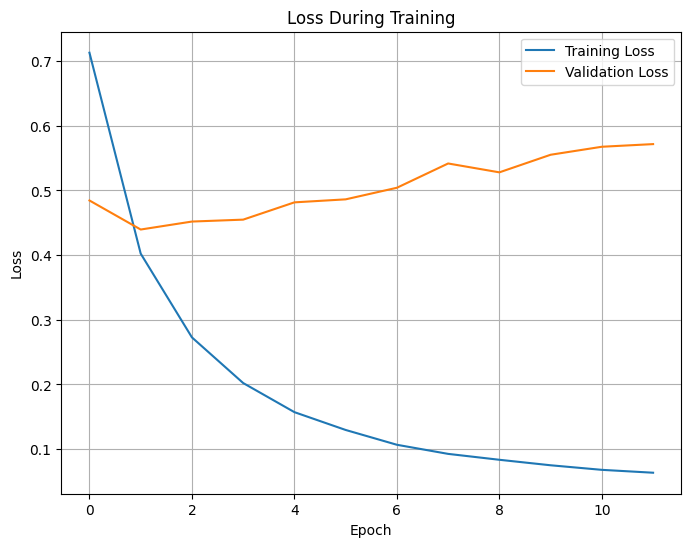

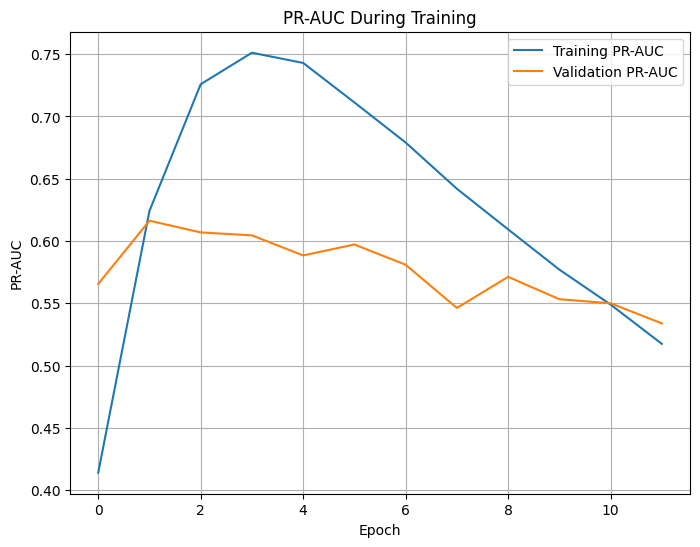

In [7]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks
)

# Plot training & validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation PR-AUC over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['pr_auc'], label='Training PR-AUC')
plt.plot(history.history['val_pr_auc'], label='Validation PR-AUC')
plt.title('PR-AUC During Training')
plt.xlabel('Epoch')
plt.ylabel('PR-AUC')
plt.legend()
plt.grid(True)
plt.show()